In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# !pip install zipfile36 --quiet
# !pip install uszipcode --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 KB 17.1 MB/s eta 0:00:00


In [5]:
# from zipfile import ZipFile
# 
# with ZipFile("src.zip", 'r') as zObject:
# 	zObject.extractall()

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from src.data.feature_extractor import FeatureExtractor
from src.data.importer import DataImporter
from src.data.ratings_dataset import RatingsDataset
from src.model.candidate_generation import CandidateGeneration
from src.model.popularity import Popularity
from src.trainer import Trainer
from src.utils import get_device
from src.model.candidate_generation_from_transformer import CandidateGenerationT

### Fetch MovieLens100k data

In [7]:
data_importer = DataImporter('http://files.grouplens.org/datasets/movielens/ml-100k.zip')
users_df, movies_df, genres, ratings_df = data_importer.import_data()

### Generate features and create examples df

In [9]:
f_extractor = FeatureExtractor(window_size=16)
examples_df = f_extractor.fit_transform(
    genres=genres,
    movies_df=movies_df,
    users_df=users_df,
    ratings_df=ratings_df
)

One-Hot user occupation matrix shape (943, 21)
One-Hot user gender matrix shape (943, 2)
One-Hot user geo area matrix shape (943, 4)
Using 90 examples per user_id
Using 32 examples per label
Examples shape  (49088, 7)


## Split train/validation examples

In [10]:
train_df, val_df = train_test_split(examples_df)

# Train Loader
train_dataset = RatingsDataset.from_df(train_df)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Validation Loader
val_dataset = RatingsDataset.from_df(val_df)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

### Train Candidate generation model

In [11]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256
USER_DIM = 64
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

In [12]:
device = get_device()

cg_model = CandidateGeneration(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(cg_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [13]:
trainer = Trainer(cg_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=7)

Epoch 1/7, train loss: 7.4252, val loss: 7.4220, time: 4.36s
Epoch 2/7, train loss: 7.4161, val loss: 7.4122, time: 1.17s
Epoch 3/7, train loss: 7.4073, val loss: 7.4058, time: 1.31s
Epoch 4/7, train loss: 7.3996, val loss: 7.3996, time: 1.16s
Epoch 5/7, train loss: 7.3929, val loss: 7.3938, time: 1.40s
Epoch 6/7, train loss: 7.3878, val loss: 7.3899, time: 1.74s
Epoch 7/7, train loss: 7.3830, val loss: 7.3850, time: 1.35s


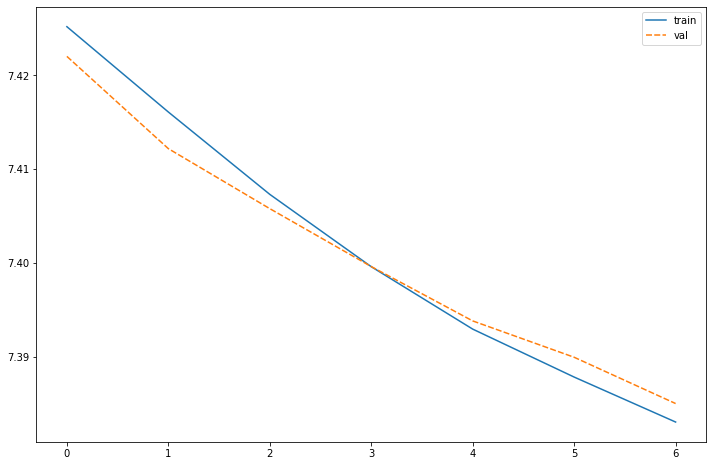

In [14]:
_, ax = plt.subplots(1, figsize=(12, 8))
sns.lineplot(data=pd.DataFrame({'train': train_losses, 'val': val_losses}), ax=ax);

### Evaluate Original Model


In [17]:
k = 10
print(f'candidate generation validation mrr @ {k}: ', cg_model.mrr(val_loader, k, device))
print(f'candidate generation validation hit rate @ {k}: ', cg_model.hit_rate(val_loader, k, device))

candidate generation validation mrr @ 10:  0.05896533792838454
candidate generation validation hit rate @ 10:  0.08720020581317205


### POP model (Baseline)

In [18]:
pop = Popularity()
pop.fit(ratings_df)

In [19]:
k = 10
print(f'popularity model validation mrr @ {k}: ', pop.mrr(val_loader, k))
print(f'popularity model validation hit rate @ {k}: ', pop.hit_rate(val_loader, k))

popularity model validation mrr @ 10:  0.00036074184148067917
popularity model validation hit rate @ 10:  0.001632854502688172


### Transformer Based Recommendations

In [20]:
device = get_device()

cgt_model = CandidateGenerationT(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(cgt_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [21]:
trainer = Trainer(cgt_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=7)

Epoch 1/7, train loss: 7.4231, val loss: 7.4194, time: 17.21s
Epoch 2/7, train loss: 7.4083, val loss: 7.4063, time: 17.22s
Epoch 3/7, train loss: 7.3997, val loss: 7.3992, time: 17.08s
Epoch 4/7, train loss: 7.3916, val loss: 7.3937, time: 17.44s
Epoch 5/7, train loss: 7.3851, val loss: 7.3858, time: 16.84s
Epoch 6/7, train loss: 7.3782, val loss: 7.3810, time: 16.75s
Epoch 7/7, train loss: 7.3743, val loss: 7.3776, time: 17.03s


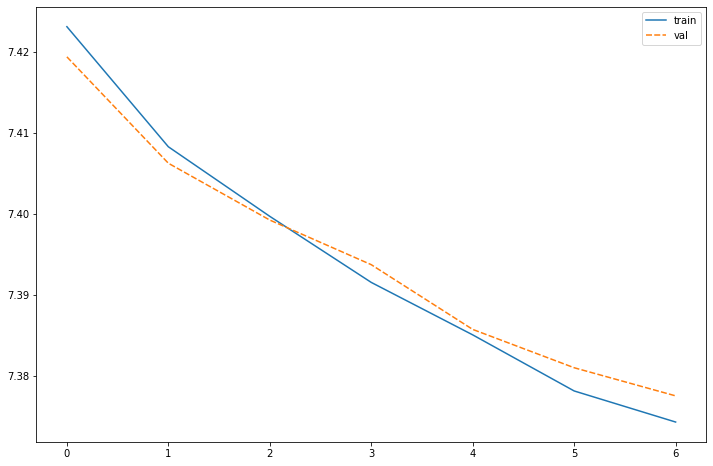

In [22]:
_, ax = plt.subplots(1, figsize=(12, 8))
sns.lineplot(data=pd.DataFrame({'train': train_losses, 'val': val_losses}), ax=ax);

### Compare models

In [25]:
results_df = pd.DataFrame(columns=['model', 'metric', 'k', 'score'])
for m, name in [
    (cg_model, 'Candidate Generation'),
    (pop, 'Popularity'),
    (cgt_model, 'Candidate Generation from Transformer')
]:
    for k in [5, 10, 20]:
        results_df.loc[results_df.shape[0]] = (name, 'mrr', k, m.mrr(val_loader, k, device=device))
        results_df.loc[results_df.shape[0]] = (name, 'hit_rate', k, m.hit_rate(val_loader, k, device=device))

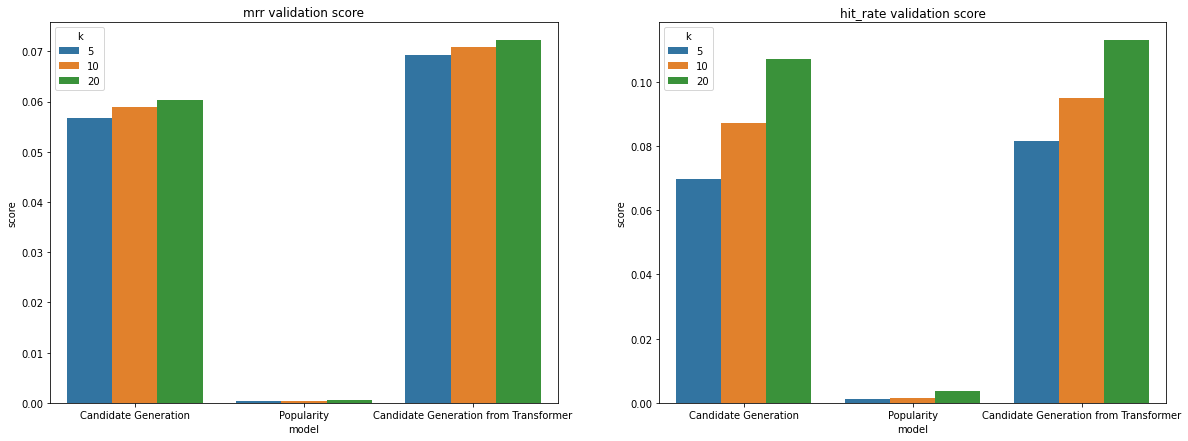

In [26]:
_, ax = plt.subplots(1,2, figsize=(20,7))
for i, metric in enumerate(['mrr', 'hit_rate']):
    data = results_df.loc[results_df.metric==metric].drop(columns=['metric'])
    sns.barplot(data=data, y='score', x='model', hue='k', ax=ax[i])
    ax[i].set(title=f'{metric} validation score')